In [7]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [9]:
def preprocess_data(seed=42):
    # Read the benign and dga data with low_memory=False
    benign = pd.read_csv("benign2lakh.csv")
    benign['class'] = 'benign'

    dga = pd.read_csv("dga2lakh.csv", low_memory=False)
    dga['class'] = 'dga'

    # Combine the dataframes
    data = pd.concat([benign, dga])

    # Update specific columns
    data['matched_word'] = data['matched_word'].apply(lambda x: '1' if pd.notna(x) and x != '' else '0').astype('category')
    data['feedback_warning'] = data['feedback_warning'].apply(lambda x: '1' if pd.notna(x) and x != '' else '0').astype('category')
    data['class'] = data['class'].astype('category')

    # Remove the 4th column (index 3 in zero-based indexing)
    data = data.drop(data.columns[3], axis=1)

    # Prepare features (X) and target (y)
    X = data.drop(columns=['class', data.columns[0]])  # Drop target and first column (Domain Names)
    y = data['class']

    # Handle NaN values by imputing with mean
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Scale the data using StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=seed)

    # Get feature names as a list
    feature_names = list(data.drop(columns=['class', data.columns[0]]).columns)

    return X_train, X_test, y_train, y_test, feature_names




In [ ]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

seed = 42
X_train, X_test, y_train, y_test, feature_names = preprocess_data(seed)

models = {
    "Random Forest": RandomForestClassifier(random_state=seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=seed),
    "SVM": SVC(random_state=seed)
}

trained_models = {}
for model_name, model in models.items():
    trained_model = train_model(model, X_train, y_train)
    trained_models[model_name] = trained_model

# Save all models in one pickle file
pickle.dump(trained_models, open('all_models_39_features.pkl', 'wb'))

In [14]:
#result on the 39 features datset
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score

# Load the trained models
with open('all_models_39_features.pkl', 'rb') as file:
    trained_models = pickle.load(file)

seed = 42
X_train, X_test, y_train, y_test, feature_names = preprocess_data(seed)

# Dictionary to store metrics for each model
model_metrics = {}

# Test each model on the test data and calculate metrics
for model_name, model in trained_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # TP / (TP + FN)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # TN / (TN + FP)

    model_metrics[model_name] = {
        'Accuracy': accuracy,
        'Kappa': kappa,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }

# Convert metrics to a DataFrame for display
metrics_df = pd.DataFrame(model_metrics).T
print(metrics_df)


                   Accuracy    Kappa  Sensitivity  Specificity
Random Forest      0.978150  0.95630     0.973940     0.982357
Gradient Boosting  0.971275  0.94255     0.963986     0.978559
SVM                0.974250  0.94850     0.966236     0.982257


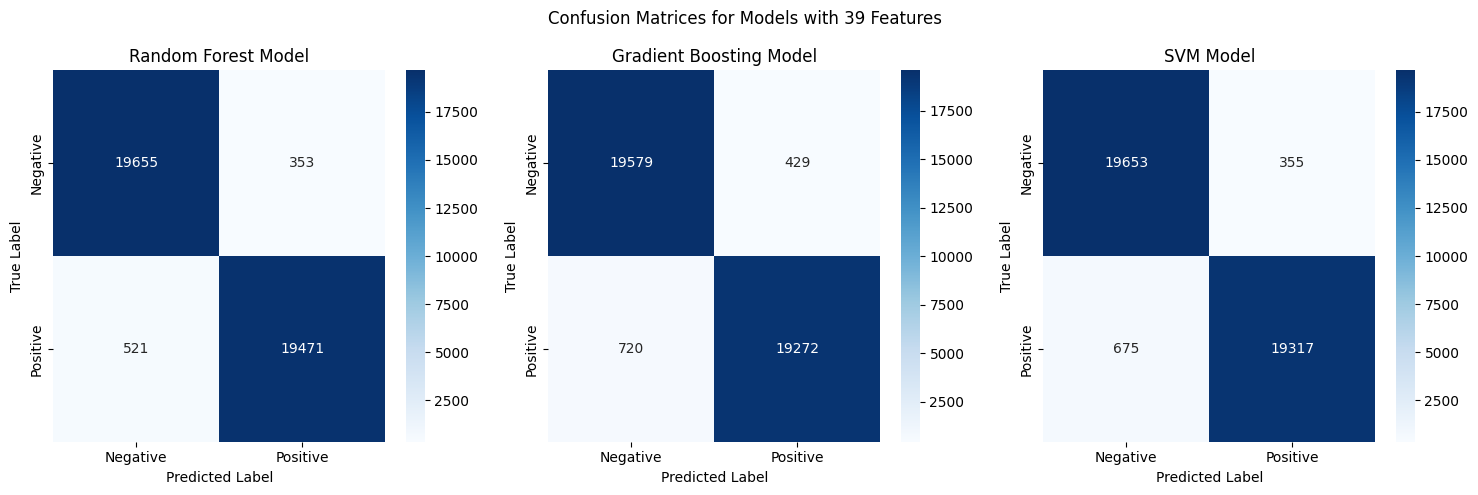

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot a confusion matrix
def plot_confusion_matrix(y_pred, ax, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Plot confusion matrices for each model
fig, axes = plt.subplots(1, len(trained_models), figsize=(15, 5))
fig.suptitle('Confusion Matrices for Models with 39 Features')

for i, (model_name, model) in enumerate(trained_models.items()):
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_pred, ax=axes[i], title=f'{model_name} Model')

plt.tight_layout()
plt.show()


In [1]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pickle
import joblib


def preprocess_data(seed, selected_features):
    # Read the benign and dga data
    benign = pd.read_csv("/content/benign2lakh.csv")
    benign['class'] = 'benign'
    dga = pd.read_csv("/content/dga2lakh.csv", low_memory=False)
    dga['class'] = 'dga'
    data = pd.concat([benign, dga])

    # Select only the specified features and the target
    data = data[selected_features + ['class']]

    y = data['class']

    data = data.drop(columns=['class'])

    # # Handle NaN values and standardize
    # imputer = SimpleImputer(strategy='mean')
    # scaler = StandardScaler()
    # X = imputer.fit_transform(data.drop(columns=['class']))
    # X = scaler.fit_transform(X)
    # y = data['class']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.10, random_state=seed)
    return X_train, X_test, y_train, y_test, data

seed = 1234
selected_features = ['mean1', 'var1', 'sd1', 'sd2', 'ccc', 'cvc', 'vcc', 'vcv', 'cc', 'vv', 'nch', 'Uchar', 'cc', 'cv', 'vc']
X_train, X_test, y_train, y_test , data = preprocess_data(seed, selected_features)

# Training models
models = {
    "Random Forest": RandomForestClassifier(random_state=seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=seed),
    "SVM": SVC(random_state=seed)
}

trained_models = {}
for model_name, model in models.items():
    trained_model = model.fit(X_train, y_train)
    trained_models[model_name] = trained_model

# Save all models in one pickle file
# pickle.dump(trained_models, open('all_models_15_features.pkl', 'wb'))
# Save all models in one joblib file
joblib.dump(trained_models, 'all_models_15_featuresJ.joblib')


['all_models_15_featuresJ.joblib']

In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
# Load the trained models for 15 features using joblib
trained_models_15_features = joblib.load('all_models_15_featuresJ.joblib')




# Dictionary to store metrics for each model
model_metrics_15_features = {}

# Test each model on the test data and calculate metrics
for model_name, model in trained_models_15_features.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # TP / (TP + FN)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # TN / (TN + FP)

    model_metrics_15_features[model_name] = {
        'Accuracy': accuracy,
        'Kappa': kappa,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }

# Convert metrics to a DataFrame for display
metrics_df_15_features = pd.DataFrame(model_metrics_15_features).T
print(metrics_df_15_features)

                   Accuracy     Kappa  Sensitivity  Specificity
Random Forest      0.967150  0.934302     0.961653     0.972705
Gradient Boosting  0.952025  0.904067     0.933254     0.970996
SVM                0.941625  0.883298     0.900428     0.983261


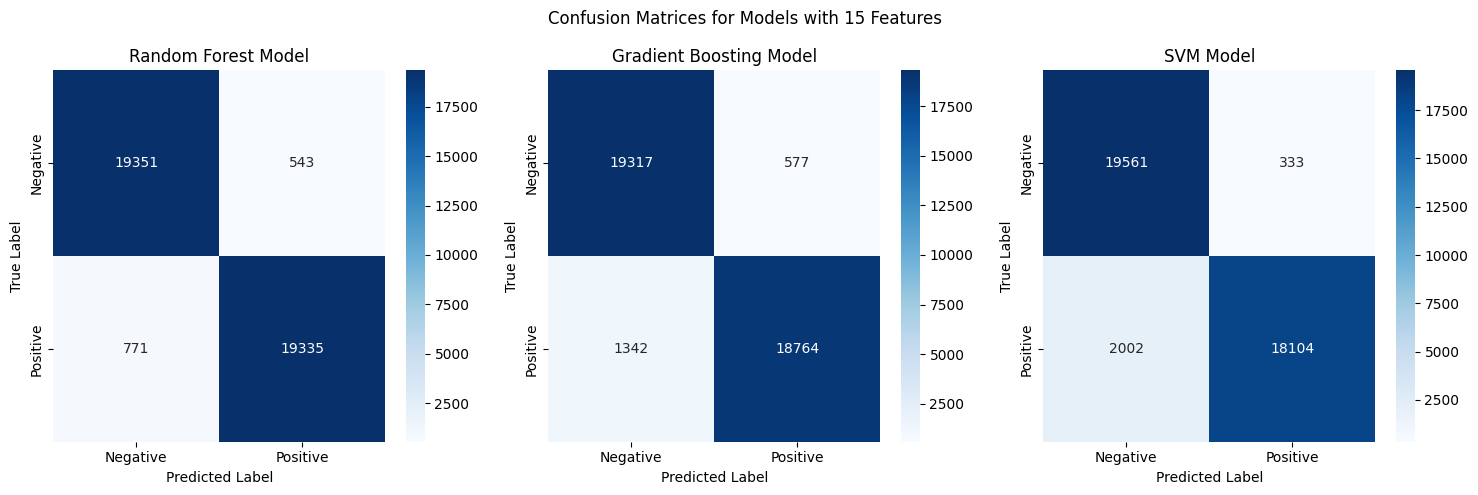

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'trained_models_15_features', 'X_test', and 'y_test' are defined as in your code

# Function to plot a confusion matrix
def plot_confusion_matrix(y_test, y_pred, ax, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Plot confusion matrices for each model
fig, axes = plt.subplots(1, len(trained_models_15_features), figsize=(15, 5))
fig.suptitle('Confusion Matrices for Models with 15 Features')

for i, (model_name, model) in enumerate(trained_models_15_features.items()):
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, ax=axes[i], title=f'{model_name} Model')

plt.tight_layout()
plt.show()

